In [10]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import psycopg2

plt.rcParams["figure.figsize"] = (20,10)
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

conn_string = "host='localhost' dbname='gbot' user='postgres' password='123'"
conn = psycopg2.connect(conn_string)
if not conn.closed:
    print("Connected!")

Connected!


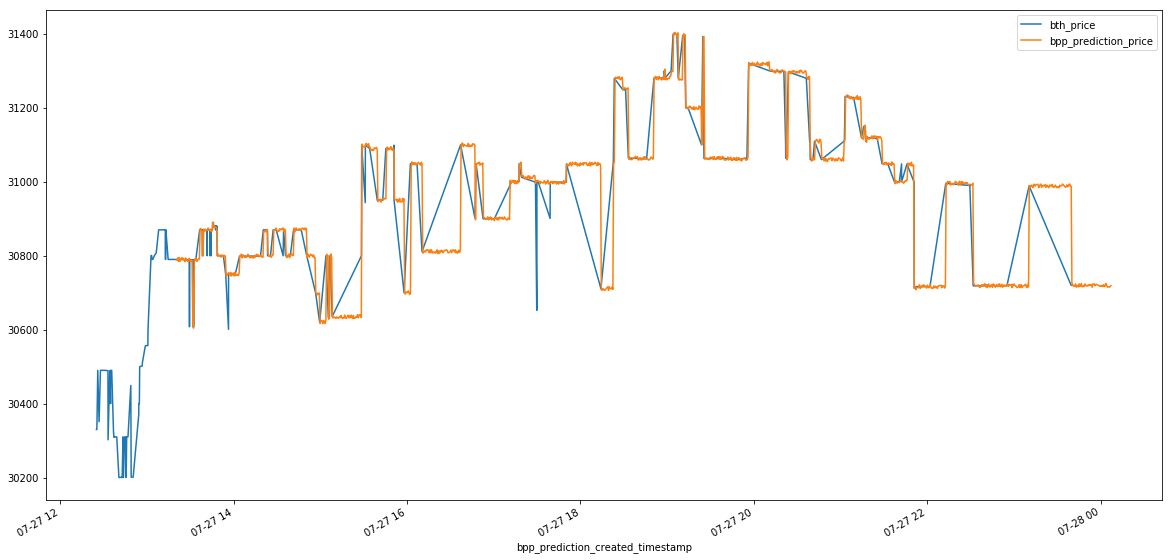

In [11]:
trade_history = pd.read_sql_query("SELECT * FROM braziliex_trade_history WHERE bth_timestamp >= (now() - interval '72 HOUR') AND bth_market = 'btc_brl'", conn)
#data.plot(x="bth_timestamp", y="bth_price")
price_prediction = pd.read_sql_query("SELECT * FROM braziliex_price_prediction WHERE bpp_prediction_for_timestamp >= (now() - interval '72 HOUR')", conn);
trade_history.head()
ax = trade_history.plot(x="bth_timestamp", y="bth_price")
price_prediction.plot(ax=ax, x="bpp_prediction_created_timestamp",y="bpp_prediction_price")

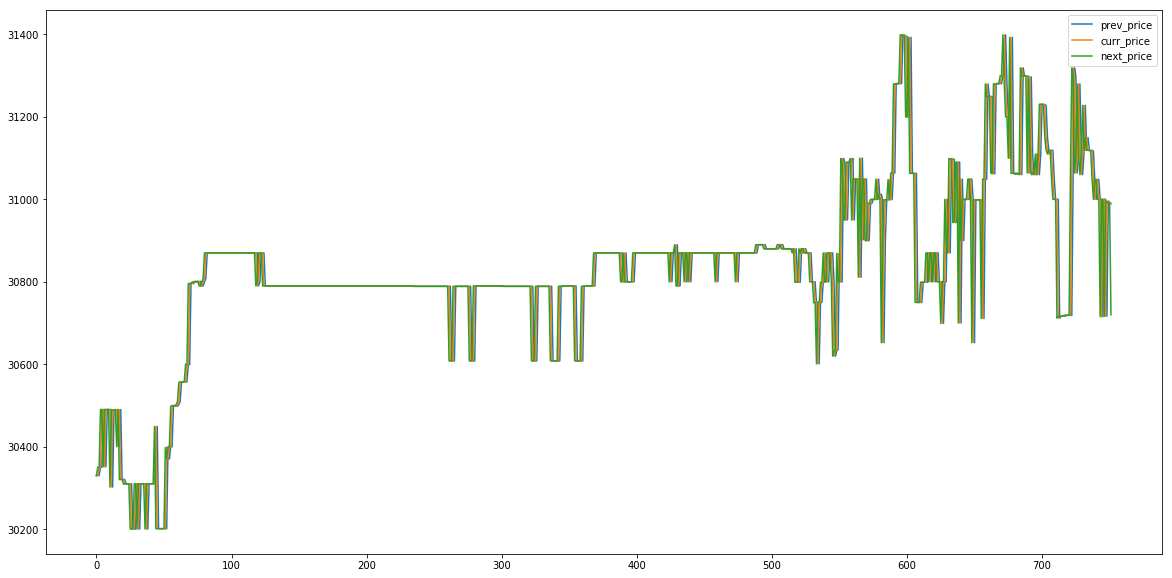

In [12]:
columns = ["prev_price", "curr_price","next_price"]
priceinfo = pd.DataFrame(columns=columns)
pricelist = trade_history["bth_price"]
for index,price in enumerate(pricelist):
    if index==0:
        continue;
    if index==len(pricelist)-1:
        break;
    prev_price = pricelist[index-1]
    next_price = pricelist[index+1]
    priceinfo = priceinfo.append({"prev_price":prev_price,"curr_price":price,"next_price":next_price}, ignore_index=True)
priceinfo.plot()

In [13]:
def preprocess_features(priceinfo):
  selected_features = priceinfo[
    ["prev_price","curr_price"]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(priceinfo):
  output_targets = priceinfo[
    ["next_price"]]
  output_targets = output_targets.copy()
  return output_targets

In [14]:
training_examples = preprocess_features(priceinfo.head(300))
training_targets = preprocess_targets(priceinfo.head(300))

validation_examples = preprocess_features(priceinfo.tail(100))
validation_targets = preprocess_targets(priceinfo.tail(100))

training_examples.head(5)

,prev_price,curr_price
0,30330.0,30330.0
1,30330.0,30330.0
2,30330.0,30350.0
3,30350.0,30350.0
4,30350.0,30490.0


In [15]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [16]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [17]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["next_price"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["next_price"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["next_price"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 16189.07
  period 01 : 3636.76
  period 02 : 49.21
  period 03 : 49.21
  period 04 : 49.22
  period 05 : 49.27
  period 06 : 49.27
  period 07 : 49.28
  period 08 : 49.31
  period 09 : 49.34
Model training finished.
Final RMSE (on training data):   49.34
Final RMSE (on validation data): 138.36


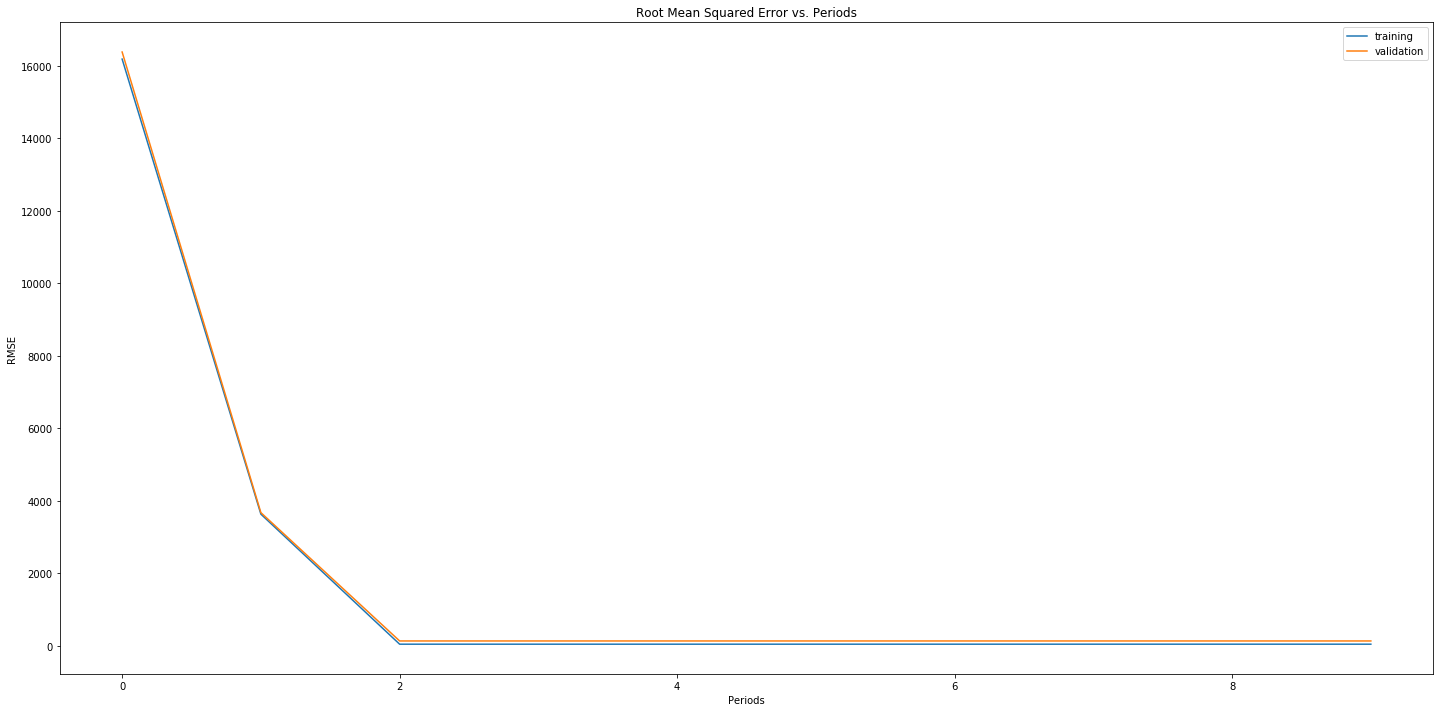

In [18]:

dnn_regressor,training_rmse,validation_rmse = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [19]:
predict_output_fun = lambda: my_input_fn(validation_examples.tail(2), 
                                                    validation_targets.tail(2)["next_price"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
predictions = dnn_regressor.predict(input_fn=predict_output_fun)
predictions = np.array([item['predictions'][0] for item in predictions])
print(validation_examples.tail(2))
print(validation_targets.tail(2))
predictions

     prev_price  curr_price
750     30993.0     30990.0
751     30990.0     30989.0
     next_price
750     30989.0
751     30719.9


array([31007.82, 31005.33], dtype=float32)

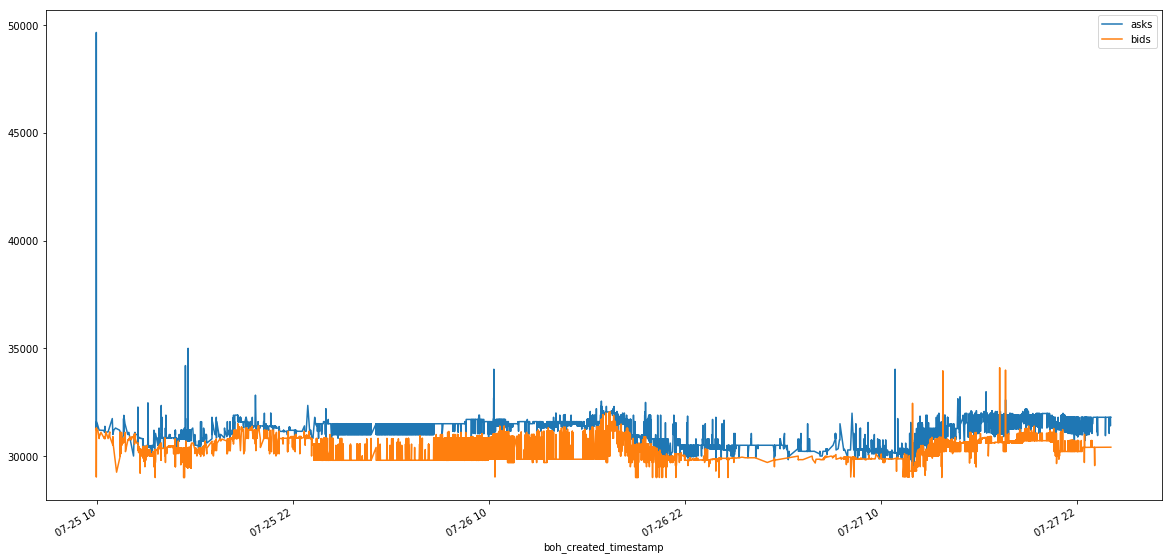

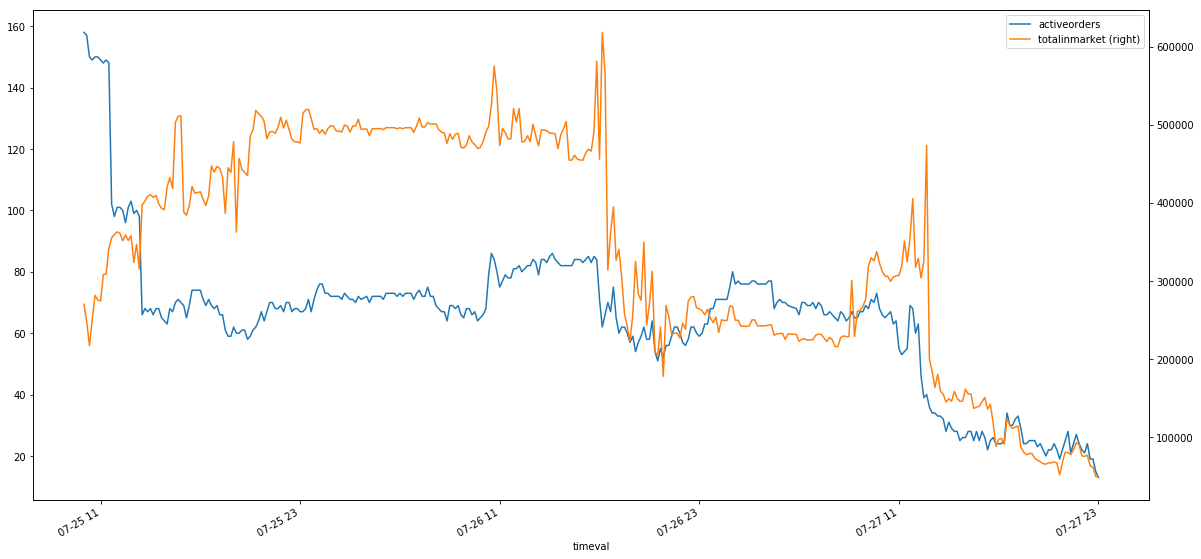

In [48]:
asks = pd.read_sql_query("SELECT *, boh_price::integer as preco FROM braziliex_orderbook_history WHERE boh_created_timestamp >= '2018-07-25 00:00:00' AND boh_market = 'btc_brl' AND boh_type = 'ask' AND boh_active = FALSE AND boh_price < 50000 AND boh_price > 29000", conn)
bids = pd.read_sql_query("SELECT *, boh_price::integer as preco FROM braziliex_orderbook_history WHERE boh_created_timestamp >= '2018-07-25 00:00:00' AND boh_market = 'btc_brl' AND boh_type = 'bid' AND boh_active = FALSE AND boh_price < 50000 AND boh_price > 29000", conn)
ax = asks.plot(x="boh_created_timestamp",y="boh_price", label="asks")
bids.plot(ax=ax,x="boh_created_timestamp",y="boh_price", label="bids")
#asks.describe()
marketByTime = pd.read_sql_query("""WITH tempos as(
SELECT to_timestamp(floor((extract('epoch' from boh_created_timestamp) / 600 )) * 600) 
AT TIME ZONE 'UTC' as timeval
FROM braziliex_orderbook_history
GROUP BY timeval
ORDER BY timeval DESC)
SELECT count(*) as activeOrders, sum(boh_initial_amount*boh_price) as totalinmarket, timeval FROM braziliex_orderbook_history INNER JOIN tempos ON boh_created_timestamp <= timeval AND boh_terminated_timestamp >= timeval
WHERE timeval >= '2018-07-25 00:00:00'
AND timeval <= '2018-07-27 23:00:00'
GROUP BY timeval""", conn);
ax2 = marketByTime.plot( x="timeval",y="activeorders");
marketByTime.plot(ax=ax2,x="timeval",y="totalinmarket",secondary_y=True)